In [ ]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

In [ ]:
import pandas as pd

In [ ]:

df_train = pd.read_csv('/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)

In [ ]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)

 
    return image

(3112,) (3112,) (550,) (550,)


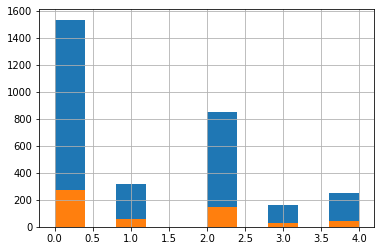

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=0)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

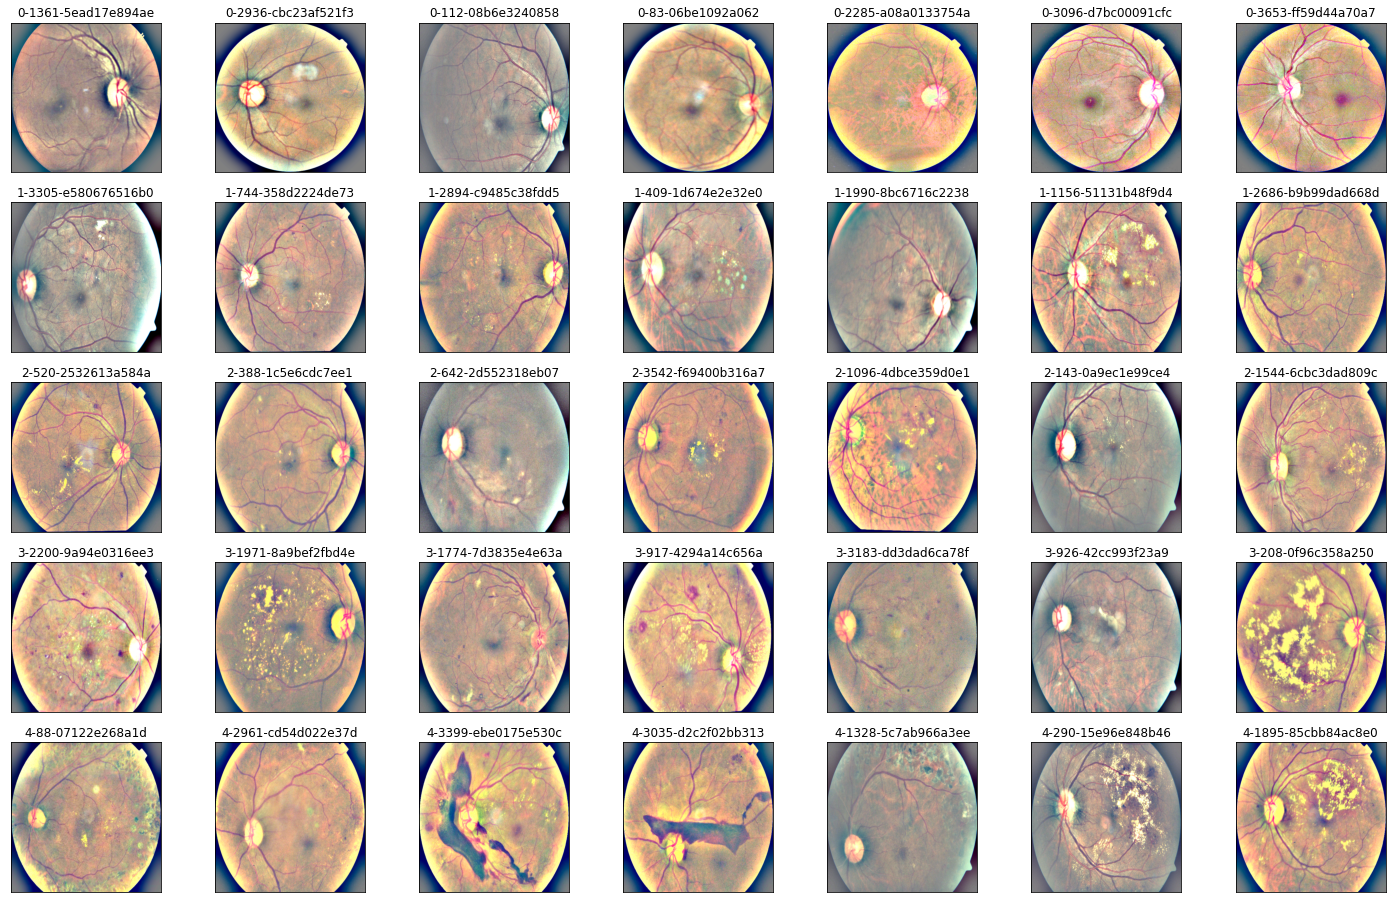

In [ ]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/train_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']))

In [ ]:
def adjust_gamma(image, gamma=1.0):

   
   table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)

In [ ]:
def extract_ma(image): 


    r,g,b=cv2.split(image)
    comp=255-g
    im = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    plt.imshow(im)
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    histe=clahe.apply(im)
    adjustImage = adjust_gamma(histe,gamma=3)
    comp = 255-adjustImage
    J =  adjust_gamma(comp,gamma=4)
    J = 255-J
    J = adjust_gamma(J,gamma=4)
    
    K=np.ones((11,11),np.float32)
    L = cv2.filter2D(J,-1,K)
    
    ret3,thresh2 = cv2.threshold(L,125,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    kernel2=np.ones((9,9),np.uint8)
    tophat = cv2.morphologyEx(thresh2, cv2.MORPH_TOPHAT, kernel2)
    kernel3=np.ones((7,7),np.uint8)
    opening = cv2.morphologyEx(tophat, cv2.MORPH_OPEN, kernel3)
    return opening

In [ ]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [ ]:
def adjust_gamma(image, gamma=1.0):

   
   table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")
   print(type(table))   
   print(table.ndim)
   print(table.shape)
   print(table.size)
   print(table.dtype)
   print(image.dtype)
   print(type(image))   
   print(image.ndim)
   print(image.shape)
   print(image.size)
   return cv2.LUT(image, table)

In [ ]:
def extract_ma(image):
    # image = preprocess_image(image)
    # grayimg = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    r,g,b=cv2.split(image)
    comp=255-g
    # im = rgb2gray(image)
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    
    histe=clahe.apply(comp)
    adjustImage = adjust_gamma(histe,gamma=3)
    comp = 255-adjustImage
    J =  adjust_gamma(comp,gamma=4)
    J = 255-J
    J = adjust_gamma(J,gamma=4)
   
    K=np.ones((11,11),np.float32)
    L = cv2.filter2D(J,-1,K)
   
    ret3,thresh2 = cv2.threshold(L,125,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    kernel2=np.ones((9,9),np.uint8)
    tophat = cv2.morphologyEx(thresh2, cv2.MORPH_TOPHAT, kernel2)
    kernel3=np.ones((7,7),np.uint8)
    opening = cv2.morphologyEx(tophat, cv2.MORPH_OPEN, kernel3)
    return opening

In [ ]:
mask = np.zeros(bloodvessel.shape, dtype=np.uint8)

thresh = cv2.threshold(mask,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=5)

cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

blobs = 0
for c in cnts:
    area = cv2.contourArea(c)
    cv2.drawContours(mask, [c], -1, (36,255,12), -1)
    if area > 13000:
        blobs += 2
    else:
        blobs += 1

print('blobs:', blobs)

plt.imshow('thresh', thresh)
.imshow('opening', opening)
cv2.imshow('image', bloodvessel)
cv2.imshow('mask', mask)

In [ ]:
print(bloodvessel)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


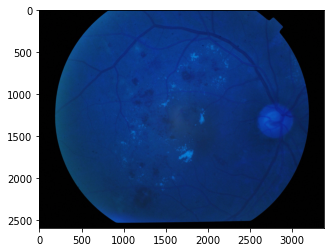

In [ ]:
        path=f"/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/train_images/ffa47f6a7bf4.png"
        fundus=cv2.imread(path)
        # fundus=rgb2gray(fundus)
        # image = load_ben_color(path,sigmaX=30)
        # bloodvessel = extract_ma(image)
#         imag = rgb2gray(bloodvessel)
        plt.imshow(fundus, vmin=0, vmax=255)

<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(1050, 1050)
1102500
<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(1050, 1050)
1102500
<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(1050, 1050)
1102500
Number of white pixels: 262


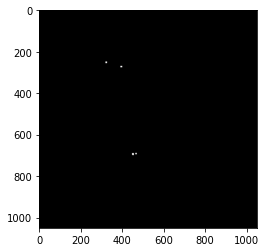

In [ ]:
        path=f"/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/train_images/ffd97f8cd5aa.png"
        fundus=cv2.imread(path)
        # image = load_ben_color(path,sigmaX=30)
        # image = cv2.resize(fundus, (4800, 4800))
        # image = cv2.resize(fundus, (5000, 5000))
        
        bloodvessel = extract_ma(fundus)
#         imag = rgb2gray(bloodvessel)
        # fundus=rgb2gray(bloodvessel)
        plt.imshow(bloodvessel, cmap=plt.get_cmap('gray'),vmin=0, vmax=255)
        n_white_pix = np.sum(bloodvessel == 255)
        print('Number of white pixels:', n_white_pix)
 

<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(1050, 1050)
1102500
<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(1050, 1050)
1102500
<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(1050, 1050)
1102500
Number of white pixels: 262


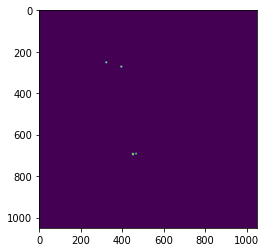

In [ ]:
        path=f"/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/train_images/ffd97f8cd5aa.png"
        fundus=cv2.imread(path)
        # image = load_ben_color(path,sigmaX=30)
        # image = cv2.resize(fundus, (4800, 4800))
        # image = cv2.resize(fundus, (5000, 5000))
        bloodvessel = extract_ma(fundus)
#         imag = rgb2gray(bloodvessel)
        # fundus=rgb2gray(bloodvessel)
        plt.imshow(bloodvessel,vmin=0, vmax=255)
        n_white_pix = np.sum(bloodvessel == 255)
        print('Number of white pixels:', n_white_pix)

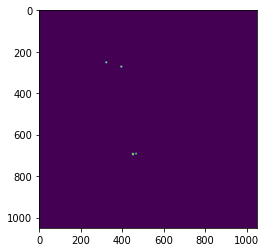

In [ ]:
plt.imshow(output)

No. of circles is 1


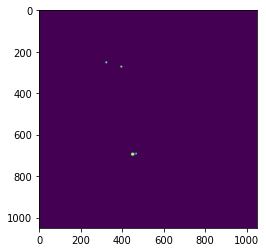

In [ ]:
circles = cv2.HoughCircles(bloodvessel,cv2.HOUGH_GRADIENT,1,20,param1=20,param2=8,
                               minRadius=0,maxRadius=500000)    
index = 0
if circles is not None:
        # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")

        # loop over the (x, y) coordinates and radius of the circles
        for (x, y, r) in circles:
            # draw the circle in the output image, 
            #   then draw a rectangle corresponding to the center of the circle
            img=cv2.circle(bloodvessel, (x, y), r, (255, 0, 255), 2)
            imag=cv2.rectangle(img, (x - 5, y - 5), (x + 5, y + 5), (255, 0, 255), -1)

            index = index + 1
            #print str(index) + " : " + str(r) + ", (x,y) = " + str(x) + ', ' + str(y)
print("No. of circles is", index)
plt.imshow(bloodvessel)
plt.imshow(imag)

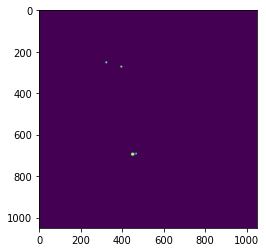

In [ ]:
plt.imshow(imag)

In [ ]:
circles = cv2.HoughCircles(bloodvessel,cv2.HOUGH_GRADIENT,1,20,param1=20,param2=8,
                               minRadius=0,maxRadius=50000)    
index = 0
if circles is not None:
        # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")

        # loop over the (x, y) coordinates and radius of the circles
        for (x, y, r) in circles:
            # draw the circle in the output image, 
            #   then draw a rectangle corresponding to the center of the circle
            # cv2.circle(output, (x, y), r, (255, 0, 255), 2)
            # cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (255, 0, 255), -1)

            index = index + 1
            #print str(index) + " : " + str(r) + ", (x,y) = " + str(x) + ', ' + str(y)
        print('No. of circles detected = {}'.format(index))

No. of circles detected = 1


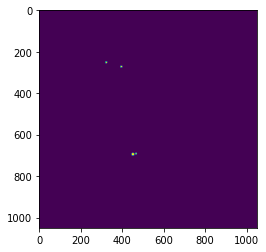

In [ ]:
plt.imshow(output)

In [ ]:
th, threshed = cv2.threshold(bloodvessel, 100, 255,  
          cv2.THRESH_BINARY|cv2.THRESH_OTSU) 
  
# findcontours 
cnts = cv2.findContours(threshed, cv2.RETR_LIST,  
                    cv2.CHAIN_APPROX_SIMPLE)[-2] 
  
# filter by area 
s1 = 3
s2 = 20
xcnts = [] 
  
for cnt in cnts: 
    if s1<cv2.contourArea(cnt) <s2: 
        xcnts.append(cnt) 
  
# printing output 
print("\nDots number: {}".format(len(xcnts))) 


Dots number: 0


In [ ]:
gray = cv2.cvtColor(bloodvessel, cv2.COLOR_RGB2GRAY)

error: ignored

In [ ]:
rgb_weights = [0.2989, 0.5870, 0.1140]


grayscale_image = np.dot(bloodvessel[...,:3], rgb_weights)

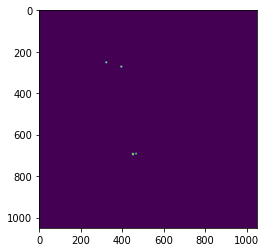

In [ ]:
plt.imshow(bloodvessel)

In [ ]:
import cv2
import numpy

red = [(0,0,240),(10,10,255)] # lower and upper 
green = [(0,240,0),(10,255,10)]
yellow = [(0,240,250),(10,255,255)]
dot_colors = [red, green, yellow]

# img = cv2.imread('./imagesStackoverflow/count_colored_dots.jpg')   
# apply medianBlur to smooth image before threshholding
blur= cv2.medianBlur(bloodvessel, 7) # smooth image by 7x7 pixels, may need to adjust a bit

for lower, upper in dot_colors:
    output = bloodvessel.copy()
    # apply threshhold color to white (255,255, 255) and the rest to black(0,0,0)
    mask = cv2.inRange(blur,lower,upper) 

    circles = cv2.HoughCircles(mask,cv2.HOUGH_GRADIENT,1,20,param1=20,param2=8,
                               minRadius=0,maxRadius=60)    
    index = 0
    if circles is not None:
        # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")

        # loop over the (x, y) coordinates and radius of the circles
        for (x, y, r) in circles:
            # draw the circle in the output image, 
            #   then draw a rectangle corresponding to the center of the circle
            cv2.circle(output, (x, y), r, (255, 0, 255), 2)
            cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (255, 0, 255), -1)

            index = index + 1
            #print str(index) + " : " + str(r) + ", (x,y) = " + str(x) + ', ' + str(y)
        print('No. of circles detected = {}'.format(index))

error: ignored

<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(3500, 3500)
12250000
<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(3500, 3500)
12250000
<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(3500, 3500)
12250000
Number of white pixels: 4305


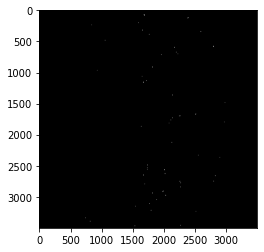

In [ ]:
        path=f"/content/drive/My Drive/22.jpg"
        fundus=cv2.imread(path)
        # image = load_ben_color(path,sigmaX=30)
        image = cv2.resize(fundus, (3500, 3500))
        bloodvessel = extract_ma(image)
#         imag = rgb2gray(bloodvessel)
        plt.imshow(bloodvessel,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        n_white_pix = np.sum(bloodvessel == 255)
        print('Number of white pixels:', n_white_pix)
        

<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(1736, 2416)
4194176
<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(1736, 2416)
4194176
<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(1736, 2416)
4194176
MA Count: 1618


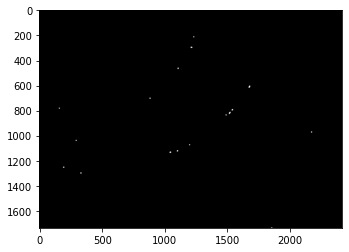

In [ ]:
        path=f"/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/train_images/fdd534271f3d.png"
        fundus=cv2.imread(path)
        # image = load_ben_color(path,sigmaX=30)
        # image = cv2.resize(fundus, (5000, 5000))
        bloodvessel = extract_ma(fundus)
#         imag = rgb2gray(bloodvessel)
        plt.imshow(bloodvessel,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        n_white_pix = np.sum(bloodvessel == 255)
        print('MA Count:', n_white_pix)

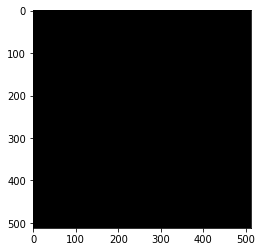

In [ ]:
        path=f"/content/drive/My Drive/22.jpg"
        # fundus=cv2.imread(path)
        image = load_ben_color(path,sigmaX=500)
        bloodvessel = extract_ma(image)
#         imag = rgb2gray(bloodvessel)
        plt.imshow(bloodvessel,cmap=plt.get_cmap('gray'), vmin=0, vmax=10000)
        # cv2.imwrite("/content/drive/My Drive/28.jpg",bloodvessel)

True

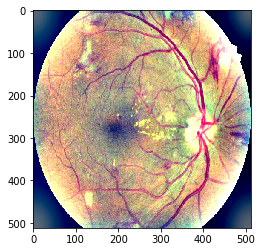

In [ ]:
        path=f"/content/drive/My Drive/22.jpg"
        # fundus=cv2.imread(path)
        image = load_ben_color(path,sigmaX=50)
        # bloodvessel = extract_ma(image)
#         imag = rgb2gray(bloodvessel)
        plt.imshow(image,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        cv2.imwrite("/content/drive/My Drive/26.jpg",bloodvessel)

In [ ]:
import cv2
import numpy as np

img = cv2.imread("/content/drive/My Drive/27.jpg", cv2.IMREAD_GRAYSCALE)
n_white_pix = np.sum(img == 255)
print('Number of white pixels:', n_white_pix)

Number of white pixels: 2819


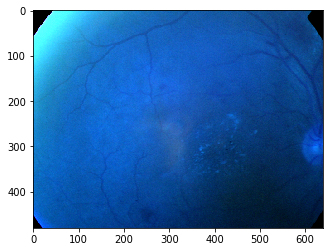

In [ ]:
        path=f"/content/drive/My Drive/Diabetic Retinopath/test_images/0005cfc8afb6.png"
        fundus=cv2.imread(path)
        # image = load_ben_color(path,sigmaX=30)
        # bloodvessel = extract_ma(image)
#         imag = rgb2gray(bloodvessel)
        plt.imshow(fundus, vmin=0, vmax=255)

MA Count: 197


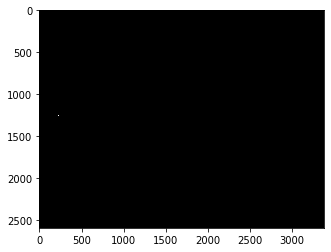

In [ ]:
        path=f"/content/drive/My Drive/Diabetic Retinopath/train_images/ffa47f6a7bf4.png"
        fundus=cv2.imread(path)
        # image = load_ben_color(path,sigmaX=30)
        bloodvessel = extract_ma(fundus)
#         imag = rgb2gray(bloodvessel)
        plt.imshow(bloodvessel,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        n_white_pix = np.sum(bloodvessel == 255)
        print('MA Count:', n_white_pix)
        # cv2.imwrite("/content/drive/My Drive/25.jpg",bloodvessel)

<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(3500, 3500)
12250000
<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(3500, 3500)
12250000
<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(3500, 3500)
12250000
MA Count: 252


True

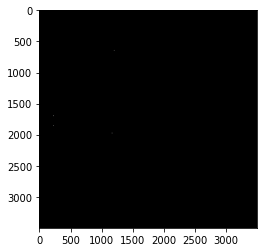

In [ ]:
        path=f"/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/train_images/ffa47f6a7bf4.png"
        fundus=cv2.imread(path)
        # image = load_ben_color(path,sigmaX=50)
        image = cv2.resize(fundus, (3500, 3500))
        bloodvessel = extract_ma(image)
        plt.imshow(bloodvessel,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        n_white_pix = np.sum(bloodvessel == 255)
        print('MA Count:', n_white_pix)
        cv2.imwrite("/content/drive/My Drive/helloz.jpg",bloodvessel)

MA Count: 2138


True

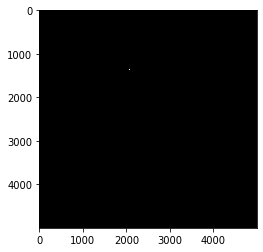

In [ ]:
        path=f"/content/drive/My Drive/Diabetic/data/train/train_split4/f69835dc7c50.png"
        fundus=cv2.imread(path)
        # image = load_ben_color(path,sigmaX=50)
        image = cv2.resize(fundus, (5000, 5000))
        bloodvessel = extract_ma(image)
        plt.imshow(bloodvessel,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        n_white_pix = np.sum(bloodvessel == 255)
        print('MA Count:', n_white_pix)
        cv2.imwrite("/content/drive/My Drive/hello1.jpg",bloodvessel)

MA Count: 3946


True

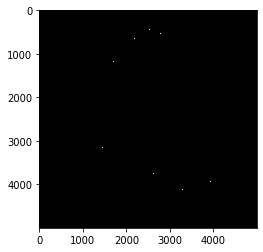

In [ ]:
        path=f"/content/drive/My Drive/Diabetic/data/train/train_split0/ffd97f8cd5aa.png"
        fundus=cv2.imread(path)
        # image = load_ben_color(path,sigmaX=50)
        image = cv2.resize(fundus, (5000, 5000))
        bloodvessel = extract_ma(image)
        plt.imshow(bloodvessel,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        n_white_pix = np.sum(bloodvessel == 255)
        print('MA Count:', n_white_pix)
        cv2.imwrite("/content/drive/My Drive/hello2.jpg",bloodvessel)

In [ ]:
import cv2
import numpy as np

img = cv2.imread("/content/drive/My Drive/24.jpg", cv2.IMREAD_GRAYSCALE)
n_white_pix = np.sum(img == 255)
print('Number of white pixels:', n_white_pix)

Number of white pixels: 0


In [ ]:
micro=[]

In [ ]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/train_images/{row['id_code']}.png"
        fundus=cv2.imread(path)
        image = cv2.resize(fundus, (3500, 3500))
        # image = load_ben_color(path,sigmaX=30)
        bloodvessel = extract_ma(image)
        n_white_pix = np.sum(bloodvessel == 255)
        micro.append(n_white_pix)
        plt.imshow(bloodvessel,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']))

In [ ]:
micron=[]

In [ ]:
print(micro)

[0, 183, 1256, 0, 0, 0, 212, 815, 0, 0, 552, 336, 272, 638, 453, 70, 0, 0, 833, 236, 407, 1135, 0, 676, 1881, 100, 0, 766, 49, 521, 946, 294, 0, 333, 517, 0, 183, 1256, 0, 0, 0, 212, 815, 0, 0, 552, 336, 272, 638, 453, 70, 0, 0, 833, 236, 407, 1135, 0, 676, 1881, 100, 0, 766, 49, 521, 946, 294, 0, 333, 517, 69, 1584, 618, 1737, 1566, 4771, 3649, 1023, 143, 242, 239, 720, 1179, 1167, 911, 487, 2219, 282, 1126, 1238, 2115, 3012, 85, 972, 3229, 126, 56, 1114, 1153, 1032, 4119, 1386, 165, 2298, 804]


In [ ]:
print(np.amax(micro))

4771


In [ ]:
print(np.amin(micro))

0


In [ ]:
print(len(micro))

105


In [ ]:
# code starts here
micron=[]
import pandas as pd

In [ ]:
y=pd.read_csv('/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/train.csv')

In [ ]:
from keras.preprocessing import image

In [ ]:
size=(299,299)
import numpy as np
import cv2

In [ ]:
micros=[]

In [ ]:
for i in y['id_code']:
  if y.loc[y['diagnosis'] <= 2]:
    img=image.load_img(('/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/train_images/'+i+".png"),target_size=size)
  # image = cv2.resize(img, (3500, 3500))
        # image = load_ben_color(path,sigmaX=30)
    imagen=cv2.resize(np.uint8(img),(3500,3500))
    microa = extract_maa(imagen)
    n_white_pix = np.sum(microa == 255)
    print(n_white_pix)
    micros.append(n_white_pix)

In [ ]:
for i in y['id_code']:
  img=image.load_img(('/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/train_images/'+i+".png"),target_size=size)
  # image = cv2.resize(img, (3500, 3500))
        # image = load_ben_color(path,sigmaX=30)
  imagen=cv2.resize(np.uint8(img),(3500,3500))
  microa = extract_maa(imagen)
  n_white_pix = np.sum(microa == 255)
  print(n_white_pix +"-")
  micron.append(n_white_pix)

In [ ]:
print(y.columns)

In [ ]:
y.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
print(micron)

[126, 412, 443, 1507, 388, 837, 633, 640, 1397, 251, 1436, 4372, 573, 1146, 2342, 1670, 241, 632, 2448, 1039, 0, 49, 299, 0, 696, 515, 289, 1154, 1232, 349, 904, 874, 769, 896, 180, 0, 936, 452, 417, 1760, 2028, 56, 188, 219, 1168, 1512, 1530, 665, 143, 379, 1813, 1804, 49, 165, 344, 890, 49, 1621, 0, 963, 740, 722, 1971, 683, 2004, 191, 341, 0, 396, 748, 326, 654, 149, 945, 1430, 1702, 909, 1612, 225, 1291, 436, 2026, 292, 415, 70, 1535, 977, 435, 261, 534, 291, 788, 376, 1468, 542, 931, 1083, 836, 142, 2325, 194, 0, 538, 2171, 284, 871, 553, 486, 1370, 499, 0, 546, 736, 932, 936, 1676, 1008, 2048, 1412, 1640, 449, 1738, 192, 103, 1260, 2916, 150, 496, 217, 813, 2109, 2180, 105, 815, 672, 120, 647, 1074, 678, 913, 119, 2950, 411, 972, 488, 75, 504, 471, 164, 2023, 772, 1275, 394, 0, 213, 352, 2132, 0, 315, 0, 559, 1769, 263, 537, 253, 1376, 0, 1109, 127, 2361, 513, 1426, 745, 1647, 49, 0, 1681, 1332, 2151, 329, 1335, 1828, 0, 127, 1240, 758, 825, 1996, 677, 1472, 256, 2073, 683, 1627,

In [ ]:
npd=[]

In [ ]:
print(npa)

[2, 4, 1, 0, 0, 4, 0, 2, 2, 1, 0, 2, 0, 3, 1, 0, 2, 0, 0, 2, 2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 4, 2, 4, 2, 0, 0, 4, 0, 4, 2, 2, 4, 2, 1, 2, 4, 0, 3, 1, 2, 2, 2, 2, 0, 3, 0, 2, 1, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 1, 0, 3, 0, 2, 0, 2, 0, 1, 3, 1, 0, 2, 0, 0, 3, 4, 2, 2, 0, 0, 0, 0, 1, 0, 3, 1, 0, 2, 2, 0, 0, 0, 4, 4, 0, 0, 1, 2, 4, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 2, 2, 0, 0, 4, 0, 0, 1, 0, 2, 0, 2, 2, 2, 1, 0, 0, 1, 0, 0, 0, 2, 0, 2, 1, 4, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 2, 2, 2, 3, 2, 0, 3, 0, 0, 0, 0, 4, 0, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 3, 1, 0, 4, 0, 0, 2, 4, 0, 1, 0, 3, 0, 2, 2, 0, 1, 0, 3, 3, 1, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 2, 2, 0, 1, 0, 4, 1, 1, 2, 4, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 2, 1, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 3, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 3, 0, 1, 2, 0, 4, 3, 0, 0, 0, 0, 3, 2, 0, 4, 0, 0, 0, 4, 3, 4, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 2, 0, 0, 0, 0, 4, 0, 2, 0, 0, 2, 1, 0, 

In [ ]:
for i in y['diagnosis']:
  sl=i
  npd.append(sl)
  

In [ ]:
l=[]

In [ ]:
l=np.vstack((micron, npd)).T

In [ ]:
print(l)

[[ 126    2]
 [ 412    4]
 [ 443    1]
 ...
 [ 384    2]
 [2095    0]
 [   0    2]]


In [ ]:
for i in range(3662):
  if l[i][1]==0:
    print(l[i]) 
    

[1507    0]
[388   0]
[633   0]
[1436    0]
[573   0]
[1670    0]
[632   0]
[2448    0]
[49  0]
[696   0]
[289   0]
[1154    0]
[1232    0]
[349   0]
[904   0]
[874   0]
[936   0]
[452   0]
[1760    0]
[143   0]
[890   0]
[1621    0]
[740   0]
[1971    0]
[683   0]
[2004    0]
[191   0]
[396   0]
[748   0]
[326   0]
[945   0]
[1702    0]
[1612    0]
[1291    0]
[415   0]
[1535    0]
[977   0]
[788   0]
[376   0]
[1468    0]
[542   0]
[1083    0]
[2325    0]
[538   0]
[2171    0]
[284   0]
[486   0]
[1370    0]
[736   0]
[932   0]
[1676    0]
[1008    0]
[2048    0]
[1412    0]
[1640    0]
[1738    0]
[1260    0]
[2916    0]
[496   0]
[217   0]
[2109    0]
[105   0]
[1074    0]
[678   0]
[119   0]
[2950    0]
[411   0]
[488   0]
[164   0]
[772   0]
[394   0]
[0 0]
[213   0]
[352   0]
[2132    0]
[0 0]
[559   0]
[1769    0]
[1109    0]
[2361    0]
[513   0]
[1426    0]
[745   0]
[49  0]
[1681    0]
[2151    0]
[329   0]
[1335    0]
[0 0]
[127   0]
[1240    0]
[758   0]
[1996    0]
[2073 

In [ ]:
def adjust_gammas(image, gamma=1.0):

   
   table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")
  #  print(type(table))   
  #  print(table.ndim)
  #  print(table.shape)
  #  print(table.size)
  #  print(table.dtype)
  #  print(image.dtype)
  #  print(type(image))   
  #  print(image.ndim)
  #  print(image.shape)
  #  print(image.size)
   return cv2.LUT(image, table)
   
def extract_maa(image):
    # image = preprocess_image(image)
    # grayimg = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    r,g,b=cv2.split(image)
    comp=255-g
    # im = rgb2gray(image)
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    
    histe=clahe.apply(comp)
    adjustImage = adjust_gammas(histe,gamma=3)
    comp = 255-adjustImage
    J =  adjust_gammas(comp,gamma=4)
    J = 255-J
    J = adjust_gammas(J,gamma=4)
   
    K=np.ones((11,11),np.float32)
    L = cv2.filter2D(J,-1,K)
   
    ret3,thresh2 = cv2.threshold(L,125,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    kernel2=np.ones((9,9),np.uint8)
    tophat = cv2.morphologyEx(thresh2, cv2.MORPH_TOPHAT, kernel2)
    kernel3=np.ones((7,7),np.uint8)
    opening = cv2.morphologyEx(tophat, cv2.MORPH_OPEN, kernel3)
    return opening

In [ ]:
print(np.amax(micron))
print(np.amin(micron))

6438
0


In [ ]:
print(np.median(micron))

721.0


In [ ]:
for i in y['id_code']:
  if y['diagnosis'] == '1':
    img=image.load_img(('/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/train_images/'+i+".png"),target_size=size)
  # image = cv2.resize(img, (3500, 3500))
        # image = load_ben_color(path,sigmaX=30)
    imagen=cv2.resize(np.uint8(img),(3500,3500))
    microa = extract_maa(imagen)
    n_white_pix = np.sum(microa == 255)
    print(n_white_pix)
    micron.append(n_white_pix)

ValueError: ignored

In [ ]:
# code ends here

In [ ]:
import numpy as np
import cv2
#from matplotlib import pyplot as plt



class ExtractExudates:
    
    jpegImg = 0
    grayImg = 0
    curImg = 0

    def setImage(self, img):
        self.jpegImg = img
        self.curImg = np.array(img)    ##Convert jpegFile to numpy array (Required for CV2)

    def getImage(self):
        return self.curImg
        
    def greenComp(self):
    ###Extracting Green Component
        gcImg = self.curImg[:,:,1]
        self.curImg = gcImg

    def applyCLAHE(self):
    #Applying Contrast Limited Adaptive Histogram Equalization (CLAHE)
        clahe = cv2.createCLAHE()
        clImg = clahe.apply(self.curImg)
        self.curImg = clImg
        
# create a CLAHE object (Arguments are optional).
#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#claheImg = clahe.apply(clImg)
#cv2.imwrite('clahe_2.jpg',claheImg)

    def applyDilation(self):
        #Creating Structurig Element
        strEl = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
        #Dilation
        dilateImg = cv2.dilate(self.curImg, strEl)
        self.curImg = dilateImg

    def applyThreshold(self):
        #Thresholding with Complement/Inverse
        retValue, threshImg = cv2.threshold(self.curImg, 220, 220, cv2.THRESH_BINARY)
        self.curImg = threshImg

    def applyMedianFilter(self):
        #Median Filtering
        medianImg = cv2.medianBlur(self.curImg,5)
        self.curImg = medianImg

In [ ]:
jpegImg = 0
grayImg = 0
curImg = 0
jpegImg = fundus
curImg = np.array(fundus)    ##Convert jpegFile to numpy array (Required for CV2)

In [ ]:
print(curImg)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
print(jpegImg)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


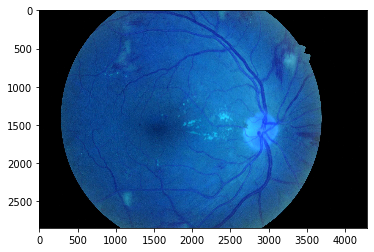

In [ ]:
path=f"/content/drive/My Drive/22.jpg"
fundus=cv2.imread(path)
        # image = load_ben_color(path,sigmaX=30)
        # bloodvessel = extract_ma(image)
#         imag = rgb2gray(bloodvessel)
plt.imshow(fundus, vmin=0, vmax=255)

In [ ]:
gcImg = curImg[:,:,1]
curImg = gcImg


In [ ]:
print(gcImg)
print(curImg)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
clahe = cv2.createCLAHE()
clImg = clahe.apply(curImg)
curImg = clImg

In [ ]:
print(clImg)

[[41 41 41 ... 41 41 41]
 [41 41 41 ... 41 41 41]
 [41 41 41 ... 41 41 41]
 ...
 [41 41 41 ... 41 41 41]
 [41 41 41 ... 41 41 41]
 [41 41 41 ... 41 41 41]]


In [ ]:
print(curImg)

[[41 41 41 ... 41 41 41]
 [41 41 41 ... 41 41 41]
 [41 41 41 ... 41 41 41]
 ...
 [41 41 41 ... 41 41 41]
 [41 41 41 ... 41 41 41]
 [41 41 41 ... 41 41 41]]


In [ ]:
strEl = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
        #Dilation
dilateImg = cv2.dilate(curImg, strEl)
curImg = dilateImg


In [ ]:
print(dilateImg)

[[41 41 41 ... 41 41 41]
 [41 41 41 ... 41 41 41]
 [41 41 41 ... 41 41 41]
 ...
 [41 41 41 ... 41 41 41]
 [41 41 41 ... 41 41 41]
 [41 41 41 ... 41 41 41]]


In [ ]:
retValue, threshImg = cv2.threshold(curImg, 220, 220, cv2.THRESH_BINARY)
curImg = threshImg

In [ ]:
medianImg = cv2.medianBlur(curImg,5)
curImg = medianImg

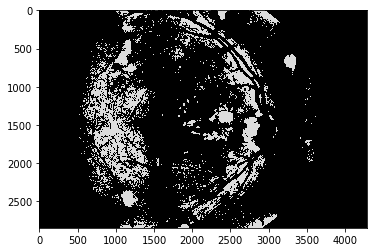

In [ ]:
plt.imshow(curImg,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

In [ ]:
kernel = np.ones((5,5), np.uint8) 
  
eye_final = cv2.dilate(curImg, kernel, iterations=1) 
eye_final = cv2.erode(eye_final, kernel, iterations=1) 
eye_final = cv2.dilate(eye_final, kernel, iterations=1)
eye_final = cv2.erode(eye_final, kernel, iterations=1)

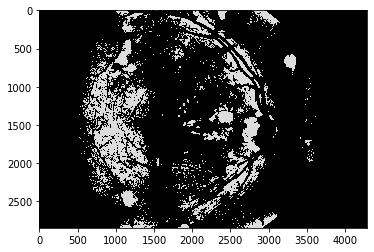

In [ ]:
plt.imshow(eye_final,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

In [ ]:
def deviation_from_mean(image):
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
	clahe_output = clahe.apply(image)
	print(clahe_output)
	result = clahe_output.copy()
	result = result.astype('int')
	i = 0
	j = 0
	while i < image.shape[0]:
		j = 0
		while j < image.shape[1]:
			sub_image = clahe_output[i:i+5,j:j+5]
			mean = np.mean(sub_image)
			sub_image = sub_image - mean
			result[i:i+5,j:j+5] = sub_image
			j = j+5
		i = i+5
	return result

In [ ]:
import numpy as np
import cv2
from numba import jit
import os
from matplotlib import pyplot as plt
import math

In [ ]:
    fundus = cv2.imread(path)
		fundus = cv2.resize(fundus,(800,615))
		fundus_mask = cv2.imread("fmask.tif")
		fundus_mask = cv2.resize(fundus_mask,(800,615))

		f1 = cv2.bitwise_and(fundus[:,:,0],fundus_mask[:,:,0])
		f2 = cv2.bitwise_and(fundus[:,:,1],fundus_mask[:,:,1])
		f3 = cv2.bitwise_and(fundus[:,:,2],fundus_mask[:,:,2])
		fundus_dash = cv2.merge((f1,f2,f3))

		b,g,r = cv2.split(fundus_dash)
		
		gray_scale = cv2.cvtColor(fundus_dash,cv2.COLOR_BGR2GRAY)
		
		ff = deviation_from_mean(gray_scale)

		print((ff>0).sum(),"greater")
		print((ff==0).sum(),"equal")
		print((ff<0).sum(),"smaller")

		print(ff[300:310,400:410])
		ff = np.reshape(ff,(ff.size,1))
		
		Z = np.hstack((ff))
		Z = np.float32(Z)

		criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.01)
		ret,label,center=cv2.kmeans(Z,5,None,criteria,50,cv2.KMEANS_RANDOM_CENTERS)
		print(center)

		u, indices, counts = np.unique(label, return_index=True, return_counts=True)
		print(u,"unique labels in Clustered image")
		print(counts,"count of labels in Clustered image")
		

		center_t = [(t[0]) for t in center]
		print(center_t,"centre relevant to me")
		print(max(center_t),"max of center")
	

		green = [0,255,0]
		blue = [255,0,0]
		red = [0,0,255]
		white = [255,255,255]
		black = [0,0,0]
		pink = [220,30,210]
		sky = [30,240,230]
		yellow = [230,230,30]

		color = [white,black,red,green,blue,pink]
		color = np.array(color,np.uint8)
		label = np.reshape(label, gray_scale.shape)


		test = label.copy()				
		test[test!=u[center_t.index(max(center_t))]] = -1
		test[test==u[center_t.index(max(center_t))]] = 255
		test[test==-1] = 0

		y = color[label]
		y = np.uint8(y)

In [ ]:
import numpy as np
import cv2
from numba import jit
import os
from matplotlib import pyplot as plt
import math
import csv
from sklearn import preprocessing



@jit
def standard_deviation_image(image):
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
	clahe_output = clahe.apply(image)
	result = clahe_output.copy()
	i = 0
	j = 0
	while i < image.shape[0]:
		j = 0
		while j < image.shape[1]:
			sub_image = clahe_output[i:i+20,j:j+25]
			var = np.var(sub_image)
			result[i:i+20,j:j+25] = var
			j = j+25
		i = i+20
	return result

@jit
def deviation_from_mean(image):
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
	clahe_output = clahe.apply(image)
	print(clahe_output)
	result = clahe_output.copy()
	result = result.astype('int')
	i = 0
	j = 0
	while i < image.shape[0]:
		j = 0
		while j < image.shape[1]:
			sub_image = clahe_output[i:i+5,j:j+5]
			mean = np.mean(sub_image)
			sub_image = sub_image - mean
			result[i:i+5,j:j+5] = sub_image
			j = j+5
		i = i+5
	return result

def get_DistanceFromOD_data(image, centre):
	my_image = image.copy()
	x_cor = centre[0]
	y_cor = centre[1]
	feature_5 = np.reshape(image, (image.size,1))
	k = 0
	i = 0
	j = 0
	while i < image.shape[0]:
		j = 0
		while j < image.shape[1]:
			feature_5[k] = math.fabs(x_cor-i) + math.fabs(y_cor-j)
			j = j+1
			k = k+1
		i = i+1
	return feature_5

@jit
def remove_bv_image(image,bv_image):
	edge_result = image[:,:,0]				
	i = 0
	j = 0
	while i < image.shape[0]:
		j = 0
		while j < image.shape[1]:
			if edge_result[i,j] == 255 and bv_image[i,j] == 255:
				edge_result[i,j] = 0
			j = j+1
		i = i+1
	return edge_result


def count_ones(image,value):
	i = 0
	j = 0 
	k = 0
	while i < image.shape[0]:
		j = 0
		while j < image.shape[1]:
			if int(image[i,j]) == value:
				k = k+1
			j = j + 1			
		i = i+1
	return k


def get_average_intensity(green_channel):
	average_intensity = green_channel.copy()
	i = 0
	j = 0
	while i < green_channel.shape[0]:
		j = 0
		while j < green_channel.shape[1]:
			sub_image = green_channel[i:i+20,j:j+25]
			mean = np.mean(sub_image)
			average_intensity[i:i+20,j:j+25] = mean
			j = j+25
		i = i+20
	result = np.reshape(average_intensity, (average_intensity.size,1))
	return result

def get_average_hue(hue_image):
	average_hue = hue_image.copy()
	i = 0
	j = 0
	while i < hue_image.shape[0]:
		j = 0
		while j < hue_image.shape[1]:
			sub_image = hue_image[i:i+20,j:j+25]
			mean = np.mean(sub_image)
			average_hue[i:i+20,j:j+25] = mean
			j = j+25
		i = i+20
	result = np.reshape(average_hue, (average_hue.size,1))
	return result

def get_average_saturation(hue_image):
	average_hue = hue_image.copy()
	i = 0
	j = 0
	while i < hue_image.shape[0]:
		j = 0
		while j < hue_image.shape[1]:
			sub_image = hue_image[i:i+20,j:j+25]
			mean = np.mean(sub_image)
			average_hue[i:i+20,j:j+25] = mean
			j = j+25
		i = i+20
	result = np.reshape(average_hue, (average_hue.size,1))
	return result



def get_SD_data(sd_image):	
	feature_1 = np.reshape(sd_image, (sd_image.size,1))
	return feature_1

def get_HUE_data(hue_image):	
	feature_2 = np.reshape(hue_image,(hue_image.size,1))	
	return feature_2

def get_saturation_data(s_image):
	feature = np.reshape(s_image,(s.size,1))	
	return feature


def get_INTENSITY_data(intensity_image):	
	feature_3 = np.reshape(intensity_image,(intensity_image.size,1))	
	return feature_3

def get_EDGE_data(edge_candidates_image):
	feature_4 = np.reshape(edge_candidates_image,(edge_candidates_image.size,1))	
	return feature_4

def get_RED_data(red_channel):	
	feature_5 = np.reshape(red_channel, (red_channel.size,1))	
	return feature_5

def get_GREEN_data(green_channel):
	feature_6 = np.reshape(green_channel, (green_channel.size,1))	
	return feature_6


def line_of_symmetry(image):
	image_v = image.copy()
	line = 0
	prev_diff = image_v.size
	for i in range(20,image_v.shape[0]-20):
		x1, y1 = image_v[0:i,:].nonzero()
		x2, y2 = image_v[i+1:image_v.shape[0],:].nonzero()
		diff = abs(x1.shape[0] - x2.shape[0])
		if diff < prev_diff:
			prev_diff = diff
			line = i
		i = i + 35
	return line

def identify_OD(image):
	newfin = cv2.dilate(image, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations=2)
	mask = np.ones(newfin.shape[:2], dtype="uint8") * 255
	y1, ycontours, yhierarchy = cv2.findContours(newfin.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
	prev_contour = ycontours[0]
	for cnt in ycontours:
		if cv2.contourArea(cnt) >= cv2.contourArea(prev_contour):
			prev_contour = cnt
			cv2.drawContours(mask, [cnt], -1, 0, -1)
	M = cv2.moments(prev_contour)
	cx = int(M['m10']/M['m00'])
	cy = int(M['m01']/M['m00'])	
	return (cx,cy)

def identify_OD_bv_density(blood_vessel_image):
	los = line_of_symmetry(blood_vessel_image)
	sub_image = blood_vessel_image[los-100:los+100,:]
	i = 0
	index = 0
	density = -1
	rr = 0	
	while i < sub_image.shape[1]:
		x1,y1 = sub_image[:,i:i+50].nonzero()
		count = x1.shape[0]		
		if(density < count):
			density = count
			index = i
		i = i + 30	
	print(los,index)
	return (index,los)


@jit
def calculate_entropy(image):
	entropy = image.copy()
	sum = 0
	i = 0
	j = 0
	while i < entropy.shape[0]:
		j = 0
		while j < entropy.shape[1]:
			sub_image = entropy[i:i+10,j:j+10]
			histogram = cv2.calcHist([sub_image],[0],None,[256],[0,256])
			sum = 0
			for k in range(256):
				if histogram[k] != 0:					
					sum = sum + (histogram[k] * math.log(histogram[k]))
				k = k + 1
			entropy[i:i+10,j:j+10] = sum
			j = j+10
		i = i+10
	ret2,th2 = cv2.threshold(entropy,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
	newfin = cv2.erode(th2, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
	return newfin

@jit
def edge_pixel_image(image,bv_image):
	edge_result = image.copy()
	edge_result = cv2.Canny(edge_result,30,100)	
	i = 0
	j = 0
	while i < image.shape[0]:
		j = 0
		while j < image.shape[1]:
			if edge_result[i,j] == 255 and bv_image[i,j] == 255:
				edge_result[i,j] = 0
			j = j+1
		i = i+1
	newfin = cv2.dilate(edge_result, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
	return newfin

def extract_bv(image):
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
	contrast_enhanced_green_fundus = clahe.apply(image)
	# applying alternate sequential filtering (3 times closing opening)
	r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
	R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
	r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
	R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
	r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
	R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
	f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
	f5 = clahe.apply(f4)

	# removing very small contours through area parameter noise removal
	ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)
	mask = np.ones(f5.shape[:2], dtype="uint8") * 255
	im2, contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
	for cnt in contours:
		if cv2.contourArea(cnt) <= 200:
			cv2.drawContours(mask, [cnt], -1, 0, -1)			
	im = cv2.bitwise_and(f5, f5, mask=mask)
	ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)			
	newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)	

	# removing blobs of microaneurysm & unwanted bigger chunks taking in consideration they are not straight lines like blood
	# vessels and also in an interval of area
	fundus_eroded = cv2.bitwise_not(newfin)
	xmask = np.ones(image.shape[:2], dtype="uint8") * 255
	x1, xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)	
	for cnt in xcontours:
		shape = "unidentified"
		peri = cv2.arcLength(cnt, True)
		approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)
		if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
			shape = "circle"	
		else:
			shape = "veins"
		if(shape=="circle"):
			cv2.drawContours(xmask, [cnt], -1, 0, -1)	
	
	finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)	
	blood_vessels = cv2.bitwise_not(finimage)
	dilated = cv2.erode(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations=1)
	#dilated1 = cv2.dilate(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
	blood_vessels_1 = cv2.bitwise_not(dilated)
	return blood_vessels_1

In [ ]:
cv2 --v


NameError: ignored

<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(1736, 2416)
4194176
<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(1736, 2416)
4194176
<class 'numpy.ndarray'>
1
(256,)
256
uint8
uint8
<class 'numpy.ndarray'>
2
(1736, 2416)
4194176
MA count 11


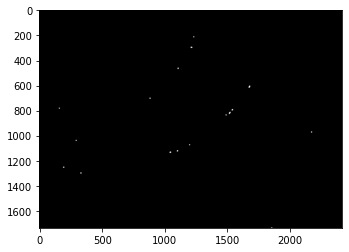

In [ ]:
        path=f"/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/train_images/fdd534271f3d.png"
        fundus=cv2.imread(path)
        # image = load_ben_color(path,sigmaX=30)
        # image = cv2.resize(fundus, (5000, 5000))
        bloodvessel = extract_ma(fundus)
#         imag = rgb2gray(bloodvessel)
        plt.imshow(bloodvessel,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        circles = cv2.HoughCircles(bloodvessel,cv2.HOUGH_GRADIENT,1,20,param1=20,param2=8,
                               minRadius=0,maxRadius=500000)    
        index = 0
        if circles is not None:
        # convert the (x, y) coordinates and radius of the circles to integers
          circles = np.round(circles[0, :]).astype("int")

        # loop over the (x, y) coordinates and radius of the circles
          for (x, y, r) in circles:
            # draw the circle in the output image, 
            #   then draw a rectangle corresponding to the center of the circle
            img=cv2.circle(bloodvessel, (x, y), r, (255, 0, 255), 2)
            imag=cv2.rectangle(img, (x - 5, y - 5), (x + 5, y + 5), (255, 0, 255), -1)

            index = index + 1
            #print str(index) + " : " + str(r) + ", (x,y) = " + str(x) + ', ' + str(y)
        print("MA count", index)


In [ ]:
microt=[]

AttributeError: ignored

In [ ]:
y=pd.read_csv('/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/train.csv')

In [ ]:
for i in y['id_code']:
  img=image.load_img(('/content/drive/My Drive/BE Pro Materials/Diabetic Retinopath/train_images/'+i+".png"))
  imagen=cv2.resize(np.uint8(img),(3500,3500))
  bloodvessel = extract_ma(fundus)
  plt.imshow(bloodvessel,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
  circles = cv2.HoughCircles(bloodvessel,cv2.HOUGH_GRADIENT,1,20,param1=20,param2=8,
                               minRadius=0,maxRadius=500000)    
  index = 0
  if circles is not None:
        # convert the (x, y) coordinates and radius of the circles to integers
          circles = np.round(circles[0, :]).astype("int")

        # loop over the (x, y) coordinates and radius of the circles
          for (x, y, r) in circles:
            # draw the circle in the output image, 
            #   then draw a rectangle corresponding to the center of the circle
            img=cv2.circle(bloodvessel, (x, y), r, (255, 0, 255), 2)
            imag=cv2.rectangle(img, (x - 5, y - 5), (x + 5, y + 5), (255, 0, 255), -1)

            index = index + 1
            #print str(index) + " : " + str(r) + ", (x,y) = " + str(x) + ', ' + str(y)
  print("MA count", index)
  microt.append(index)

AttributeError: ignored